<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/DissertationProject_v0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/drive


In [2]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    import torch
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install --target=$nb_path fvcore iopath
        !pip install --target=$nb_path --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install --target=$nb_path 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-08-07 09:41:51--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-08-07 09:41:51 (26.0 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [4]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [6]:
device

device(type='cuda', index=0)

In [7]:
def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

In [8]:
fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

In [9]:
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1,
    bin_size=None
)

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(8, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -15.0]])


# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device
    )
)

In [10]:
import numpy as np


def render(batch_size, camera_dist, mesh):
  num_cameras = int(batch_size/3)
  meshes = mesh.extend(batch_size)

  azim = np.linspace(-180, 180, num_cameras, endpoint=False)
  elev_a = np.linspace(45, 45, num_cameras, endpoint=False)
  elev_b = np.linspace(-45, -45, num_cameras, endpoint=False)
  elev_c = np.linspace(0, 0, num_cameras, endpoint=False)

  lights = AmbientLights(device=device)

  Ra, Ta = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_a)
  Rb, Tb = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_b)
  Rc, Tc = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_c)

  R = np.concatenate((Ra, Rb, Rc), axis=0)
  T = np.concatenate((Ta, Tb, Tc), axis=0)

  cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

  images = renderer(meshes, cameras=cameras, lights=lights).cpu().numpy()

  return images, num_cameras

In [11]:
table_offset = table_mesh.verts_padded().new_tensor([0, 0, -1]).expand(table_mesh.verts_packed().shape)
fruit_offset = fruit_mesh.verts_padded().new_tensor([0, 0, 0]).expand(fruit_mesh.verts_packed().shape)
double_mesh = join_meshes_as_scene([fruit_mesh.clone().scale_verts(0.1).offset_verts_(fruit_offset), table_mesh.clone().scale_verts(3.5).offset_verts_(table_offset)])

In [12]:
# plot_batch_individually(fruit_mesh)

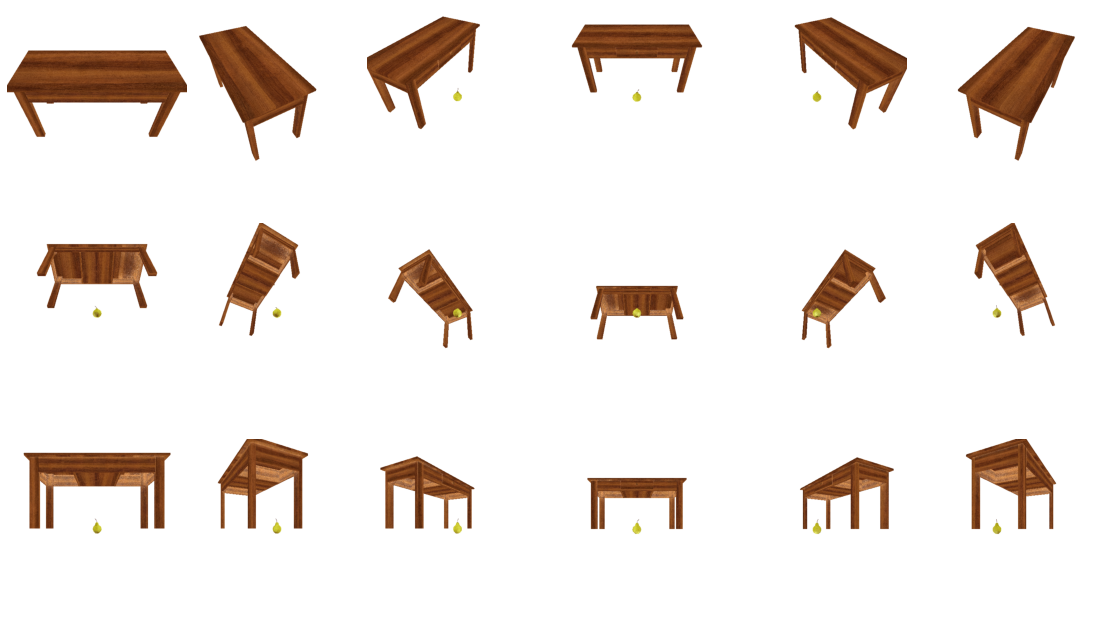

In [13]:
images, num_cameras = render(18,6, double_mesh)
image_grid(images, rows=3, cols=num_cameras, rgb=True)

In [14]:
try:
  import clip
except ModuleNotFoundError:
  !pip install git+https://github.com/openai/CLIP.git
  import clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yorsqpul
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-yorsqpul
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=e23a2b27fe6f54f174786b16e4535b0f4d96067422d23e845f61b84dbe233ce0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2g9z7re4/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [15]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 27.3MiB/s]


In [17]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [18]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
def get_similarity(images: list, description: str):
  text_tokens = clip.tokenize([description]).cuda()
  images = map(preprocess, images)
  image_input =  torch.tensor(np.stack(images)).cuda()
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  return similarity[0]

In [20]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [21]:
def get_pil_image(input):
  return Image.fromarray((input * 255).astype('uint8'))

In [22]:
# image = get_pil_image(images[12, ..., :3])
# result = get_similarity([image], "a fruit place under a table")

In [23]:
# result

In [ ]:
try:
  import tensorforce
except ModuleNotFoundError:
  !pip install git+https://github.com/tensorforce/tensorforce.git
  import tensorforce

In [25]:
class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)


In [37]:
fruit_object = SceneObject(fruit_mesh, scale=0.04)
fruit_object.position=[0,0,0]

table_object = SceneObject(table_mesh)
table_object.position=[0,0,0]

In [27]:
double_mesh = join_meshes_as_scene([table_mesh, fruit_object.mesh])

In [28]:
plot_batch_individually(double_mesh)

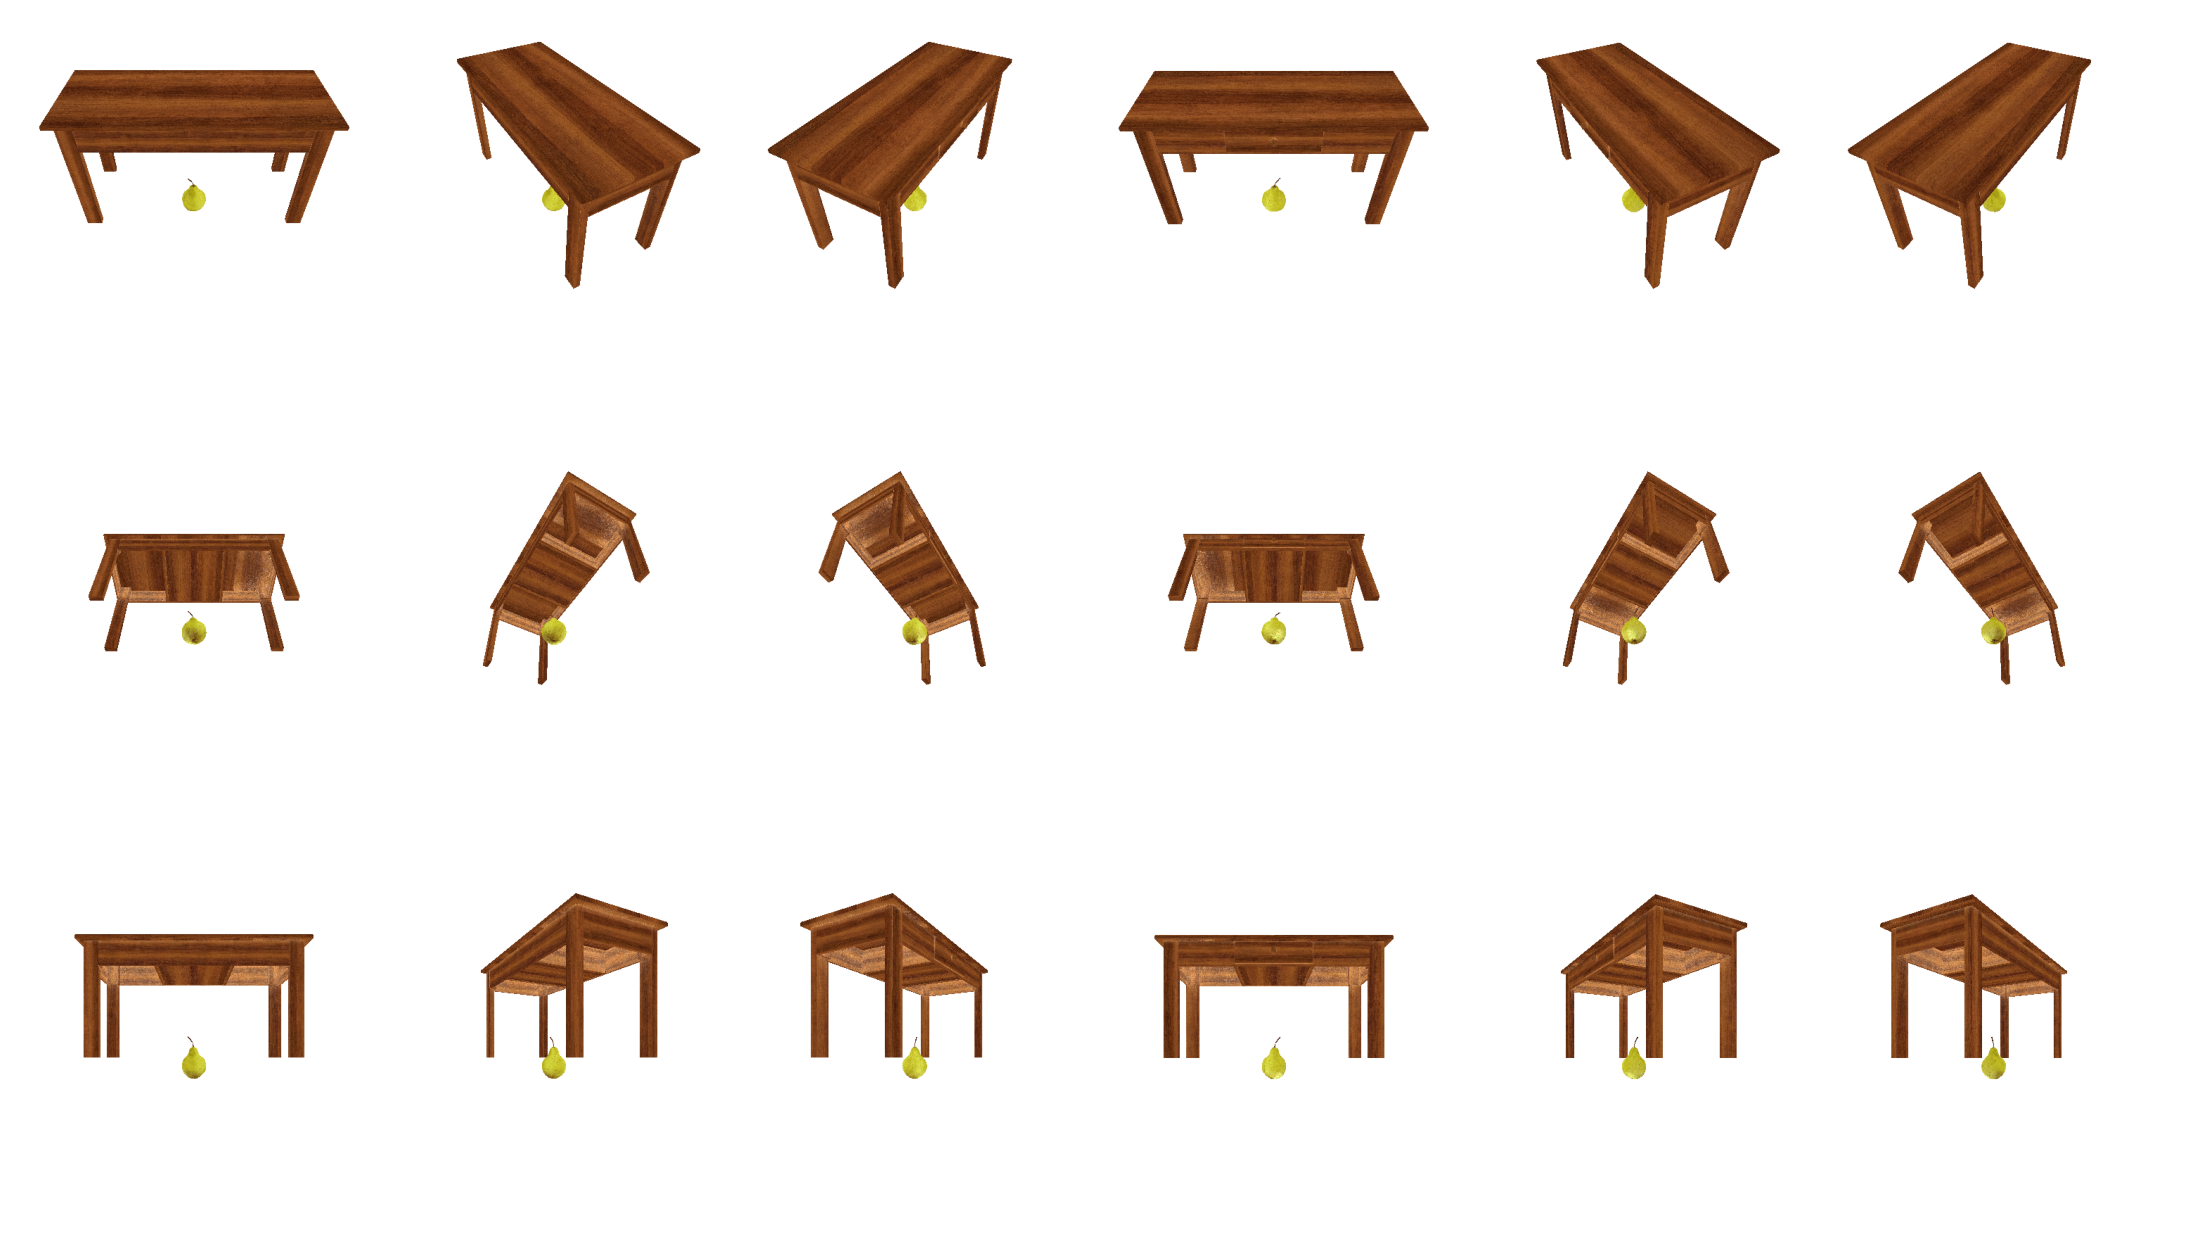

In [29]:
images, num_cameras = render(18,1.7, double_mesh)
image_grid(images, rows=3, cols=num_cameras, rgb=True)

In [204]:
class Scene():
  def __init__(self, mesh: list):
    self._mesh = mesh
    self.CAMERA_DIST = 2.5
    self.AZIM = -180
    self.ELEV = 45
    self._scene = join_meshes_as_scene(mesh)

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value)

  @property
  def _lights(self):
    return AmbientLights(device=device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=512, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=SoftPhongShader(
            device=device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [38]:
scene = Scene(mesh=[table_mesh, fruit_object.mesh])
image_a = scene.render()

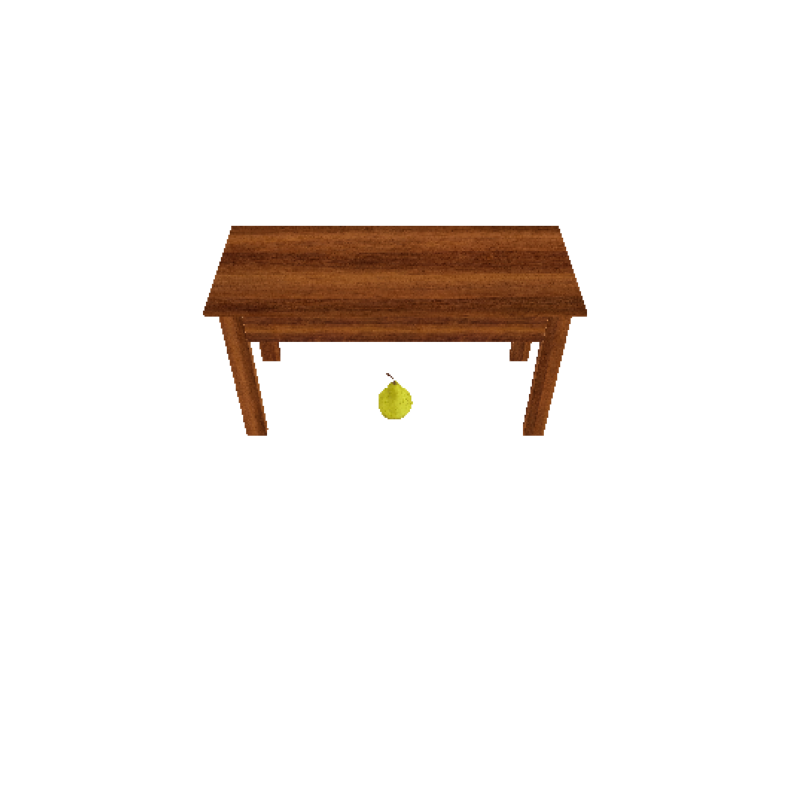

In [39]:
plt.figure(figsize=(7, 7))
plt.imshow(image_a[0, ..., :3])
plt.grid("off");
plt.axis("off");

In [40]:
fruit_object.translate([0.5,0.0,0.0])
scene.scene = [table_mesh, fruit_object.mesh]
image_b = scene.render()

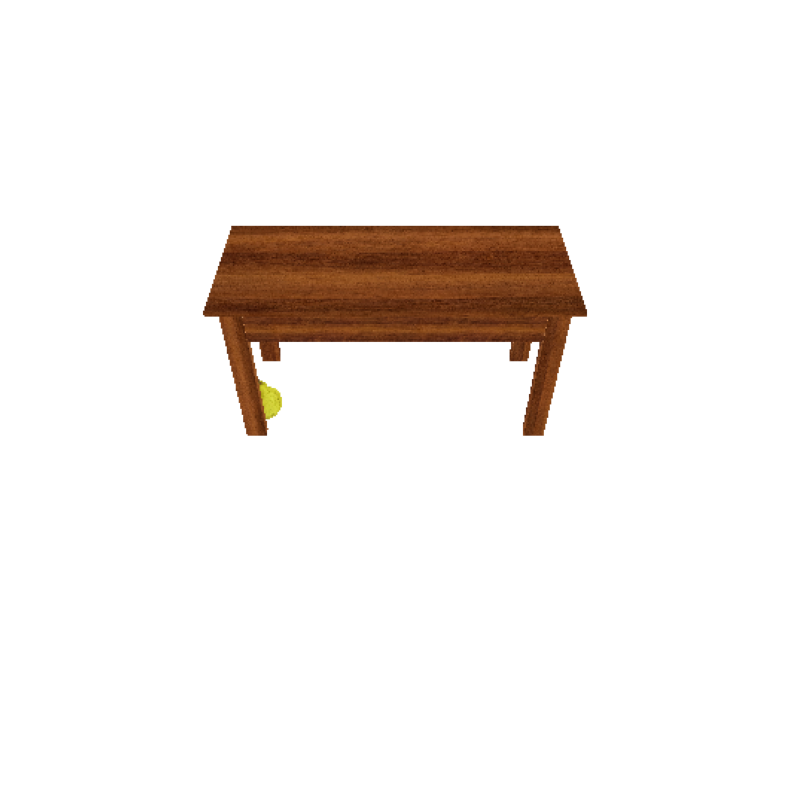

In [41]:
plt.figure(figsize=(7, 7))
plt.imshow(image_b[0, ..., :3])
plt.grid("off");
plt.axis("off");

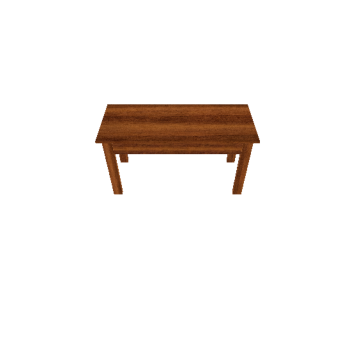

In [199]:
fruit_object.translate([-0.5,0.0,0.0])
scene.scene = [table_mesh, fruit_object.mesh]
image_c = scene.render()
plt.figure(figsize=(3, 3))
plt.imshow(image_c[0, ..., :3])
plt.grid("off");
plt.axis("off");

In [74]:
# from tensorforce.environments import Environment


# class CustomEnvironment(Environment):

#     def __init__(self):
#       super().__init__()
#       self.objs =  [fruit_object, table_object]
#       self.scene = Scene([a.mesh for a in self.objs])
#       self.STATES_SIZE = 4
#       self.GUIDE_STRING = "A piece of green fruit resting on top of a wooden table"
#       self.max_step_per_episode = 10
#       self.finished = False
#       self.episode_end = False
#       self.timestep = 0
#       self.similarity = 0

#     def transistion_function(self, action):
#       self.timestep += 1
#       fruit = self.objs[0]
#       fruit.translate(action)
#       self.objs[0] = fruit
#       return [*fruit.position, self.similarity]

#     def states(self):
#       return dict(type='float', shape=(self.STATES_SIZE,))

#     def actions(self):
#       positive_directions = [
#         [0.01,0,0], # +X
#         [0,0.01,0], # +Y
#         [0,0,0.01] # +Z
#       ]
#       return [
#         *positive_directions,
#         *list(map(lambda x: [a * -1 for a in x], positive_directions))
#       ]

#     def reward(self):
#       self.scene = Scene([a.mesh for a in self.objs])
#       image = self.scene.render()
#       pil_image = get_pil_image(image[0, ..., :3])
#       reward = get_similarity(image, self.GUIDE_STRING)
#       self.similarity = reward
#       return reward
    
#     def max_episode_timesteps(self):
#       return self.max_step_per_episode

#     def terminal(self):
#       self.episode_end = self.timestep > self.max_step_per_episode
#       return self.episode_end

#     # Optional additional steps to close environment
#     def close(self):
#       super().close()

#     def reset(self):
#       state = list(np.zeros(shape=(self.STATES_SIZE,)))
#       return state

#     def execute(self, actions):
#       next_state = None # self.transistion_function(actions)
#       terminal = self.terminal()
#       reward = self.reward()
#       return next_state, terminal, reward

In [180]:
def clip_similarity(images: list, description: str):
  text_tokens = clip.tokenize([description]).cuda()
  images = map(preprocess, images)
  image_input =  torch.tensor(np.stack(images)).cuda()
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  return similarity[0]

In [174]:
def get_pil_image(input):
  return Image.fromarray((input * 255).astype('uint8'))

In [221]:
fruit_object = SceneObject(fruit_mesh, scale=0.04)
fruit_object.position=[-0.5,0,0]

table_object = SceneObject(table_mesh)
table_object.position=[0,0,0]

In [228]:
from gym import Env
from gym.spaces import Box, Discrete
import random
import copy

class CustomTrain(Env):
    def __init__(self):
        self.obs_space = Box(low=0, high=1, shape=(1,))
        self.action_space = Box(low=-0.1, high=0.1, shape=(3,), dtype=np.float32)
        self.rounds = 50
        self.collected_reward = -1 
        self.GUIDE_STRING = "A piece of green fruit resting on top of a wooden table"
        self.objs =  [copy.deepcopy(fruit_object), copy.deepcopy(table_object)]
        self.scene = Scene([a.mesh for a in self.objs])
        self.state = self.objs[0].position
        self.prev_sim = -1
        self.image = None

    def get_similarity(self):
      self.scene = Scene([a.mesh for a in self.objs])
      image = self.scene.render()
      pil_image = get_pil_image(image[0, ..., :3])
      self.image = pil_image
      reward = clip_similarity([pil_image], self.GUIDE_STRING)
      return reward
    
    def step(self, action):
        done = False
        info = {}
        rw = 0
        self.rounds -= 1


        self.objs[0].translate(action)


        self.scene = [a.mesh for a in self.objs]

        obs = self.objs[0].position

        print(obs)

        similarity = self.get_similarity()

        if similarity > self.prev_sim:
          rw = 1
        elif similarity < self.prev_sim:
          rw = -1

        self.collected_reward += rw
        self.prev_sim = similarity
  
        if self.rounds == 0:
            done = True
        
        self.render(similarity, rw)
            
        return obs, self.collected_reward, done, info
    
    def reset(self):
        self.state = [0,0,0]

        return self.state  

    def render(self, similarity, rw):
        print(f"Round : {self.rounds}\nCLIP Score : {similarity} \nReward Received: {rw}")
        print(f"Total Reward : {self.collected_reward}")
        plt.figure(figsize=(3, 3))
        plt.imshow(self.image)
        plt.grid("off");
        plt.axis("off");

[-0.401, 0.062, 0.007]
Round : 49
CLIP Score : [0.24817102] 
Reward Received: 1
Total Reward : 0
[-0.359, 0.053, 0.094]
Round : 48
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.294, 0.087, 0.184]
Round : 47
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.341, 0.01, 0.196]
Round : 46
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.353, -0.011, 0.216]
Round : 45
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.309, 0.031, 0.118]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/usr/local/lib/python3.7/dist-packages/gym/core.py:52: DeprecationWarning:

WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/



Round : 44
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.338, 0.009, 0.067]
Round : 43
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.421, 0.072, 0.021]
Round : 42
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.403, 0.06, 0.006]
Round : 41
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.433, -0.017, 0.025]
Round : 40
CLIP Score : [0.2727077] 
Reward Received: 1
Total Reward : 1
[-0.392, 0.08, 0.011]
Round : 39
CLIP Score : [0.24817102] 
Reward Received: -1
Total Reward : 0
[-0.312, 0.137, 0.016]
Round : 38
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.369, 0.127, 0.021]
Round : 37
CLIP Score : [0.24817102] 
Reward Received: 0
Total Reward : 0
[-0.285, 0.184, 0.061]
Round : 36
CLIP Score : [0.24812901] 
Reward Received: -1
Total Reward : -1
[-0.249, 0.112, 0.075]
Round : 35
CLIP Score : [0.24817102] 
Reward Received: 1
Total Reward : 0
[-0.317, 0.14, 0.095]
Round : 34
CLIP Score : [0.248

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Round : 16
CLIP Score : [0.24822891] 
Reward Received: 1
Total Reward : 1
[-0.279, 0.31, -0.057]
Round : 15
CLIP Score : [0.3165211] 
Reward Received: 1
Total Reward : 2
[-0.222, 0.375, 0.015]
Round : 14
CLIP Score : [0.33353317] 
Reward Received: 1
Total Reward : 3
[-0.16, 0.323, 0.04]
Round : 13
CLIP Score : [0.32260823] 
Reward Received: -1
Total Reward : 2
[-0.182, 0.412, 0.088]
Round : 12
CLIP Score : [0.3463493] 
Reward Received: 1
Total Reward : 3
[-0.208, 0.312, 0.089]
Round : 11
CLIP Score : [0.3345349] 
Reward Received: -1
Total Reward : 2
[-0.207, 0.354, 0.13]
Round : 10
CLIP Score : [0.34607336] 
Reward Received: 1
Total Reward : 3
[-0.184, 0.33, 0.176]
Round : 9
CLIP Score : [0.34586322] 
Reward Received: -1
Total Reward : 2
[-0.195, 0.281, 0.1]
Round : 8
CLIP Score : [0.27016902] 
Reward Received: -1
Total Reward : 1
[-0.195, 0.23, 0.004]
Round : 7
CLIP Score : [0.24822581] 
Reward Received: -1
Total Reward : 0
[-0.154, 0.224, 0.056]
Round : 6
CLIP Score : [0.24745911] 
R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



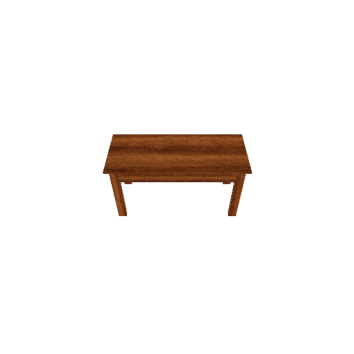

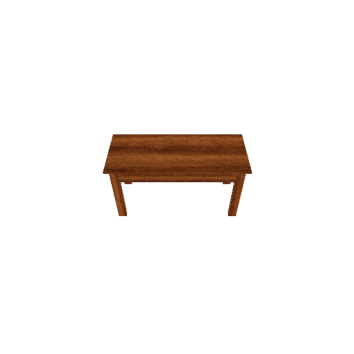

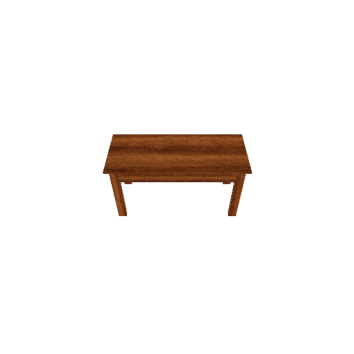

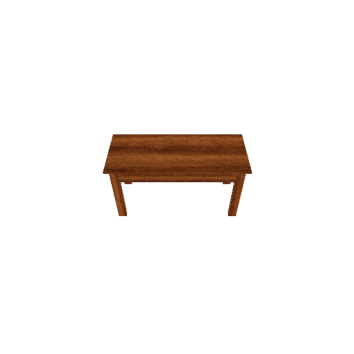

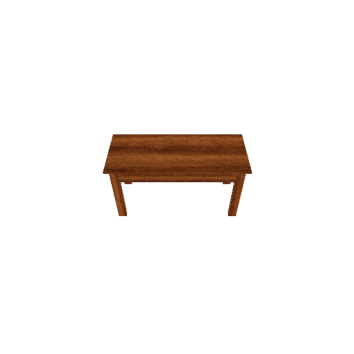

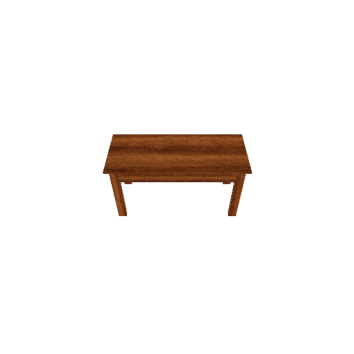

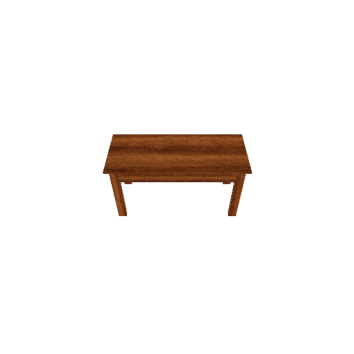

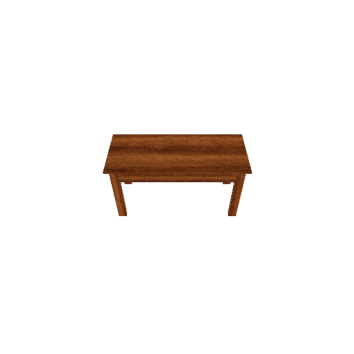

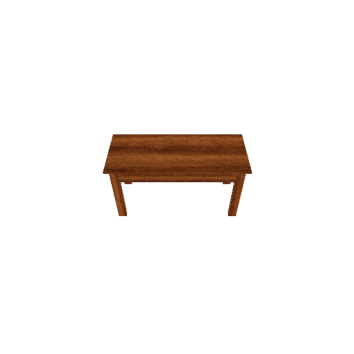

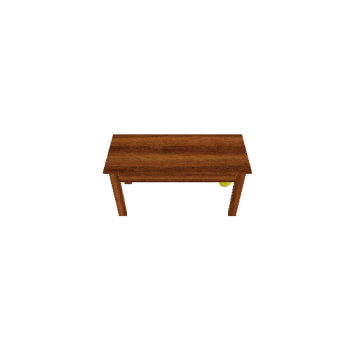

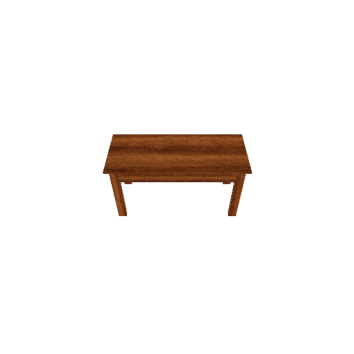

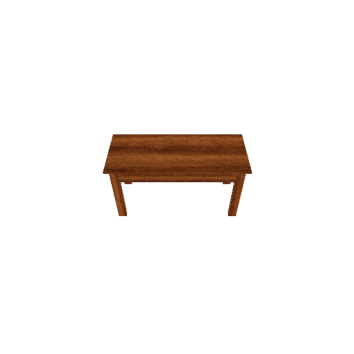

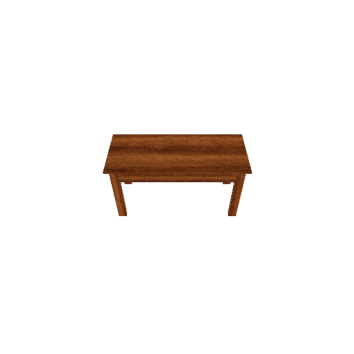

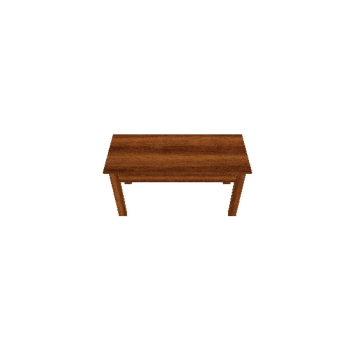

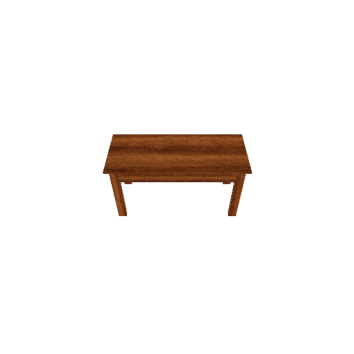

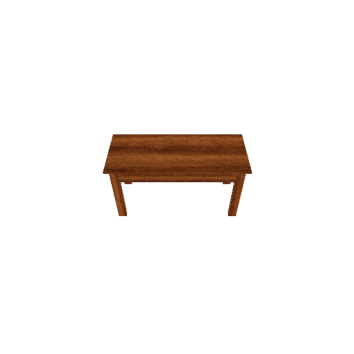

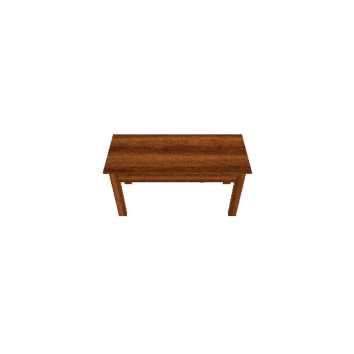

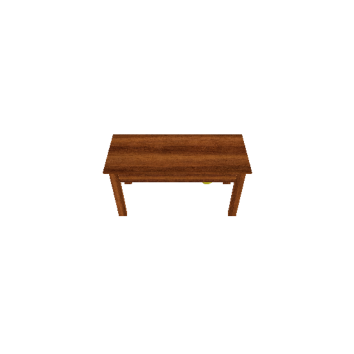

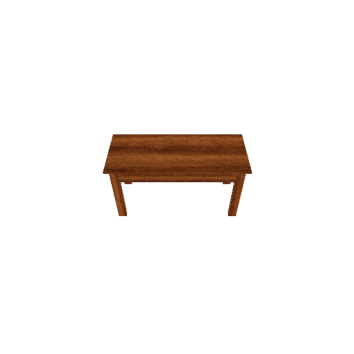

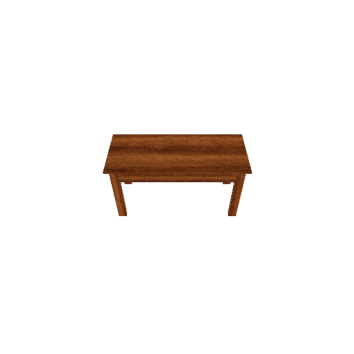

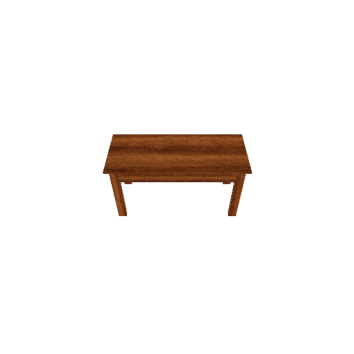

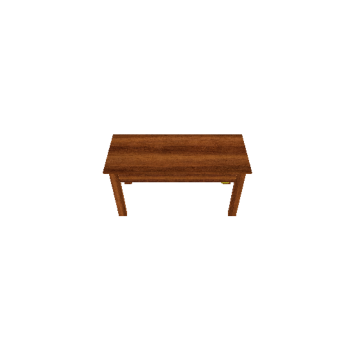

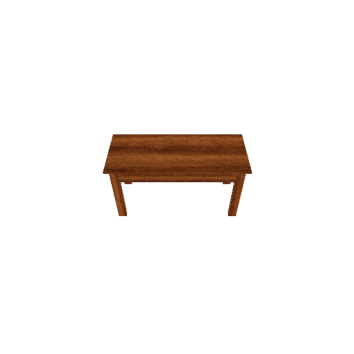

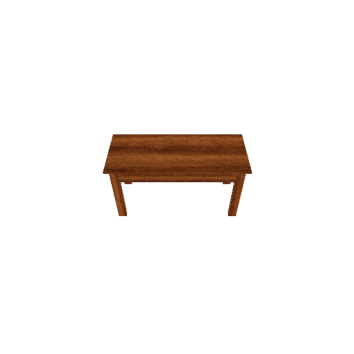

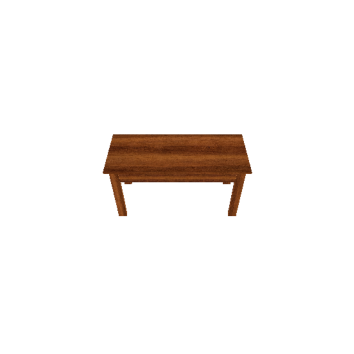

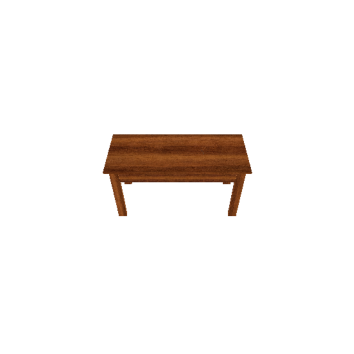

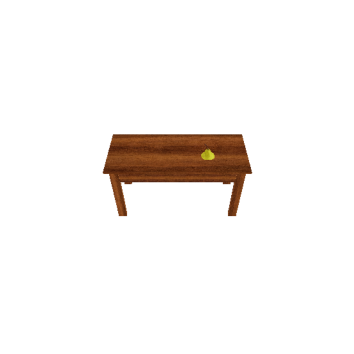

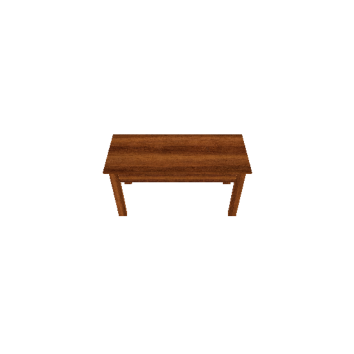

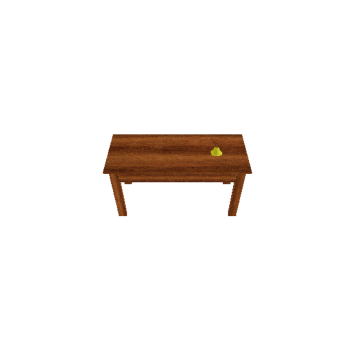

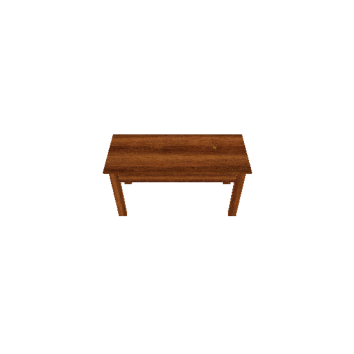

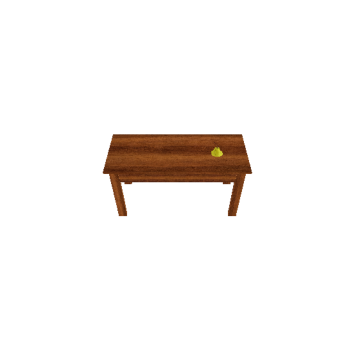

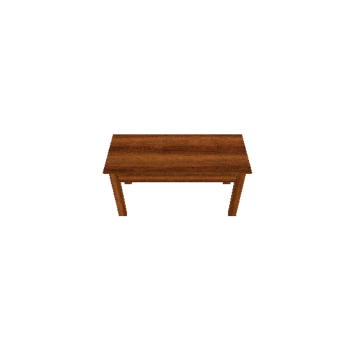

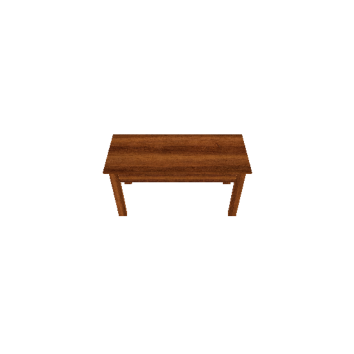

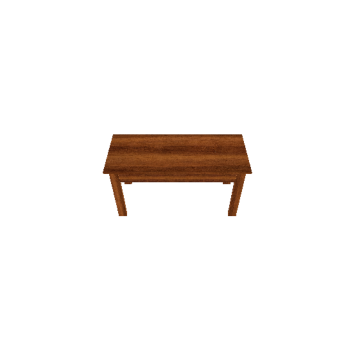

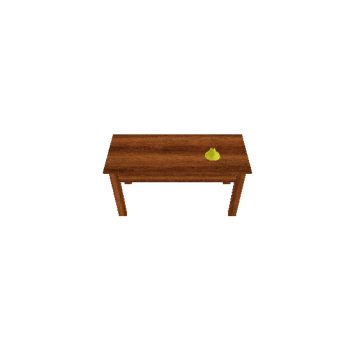

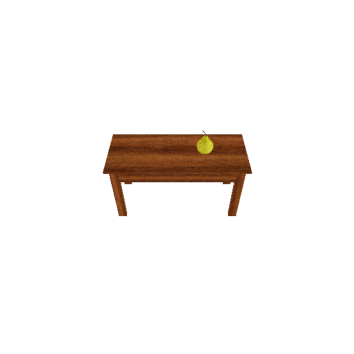

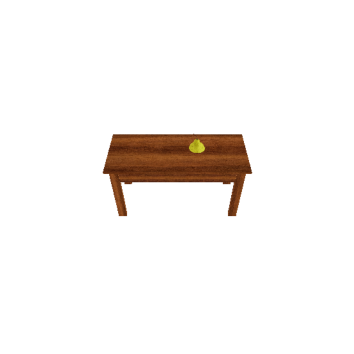

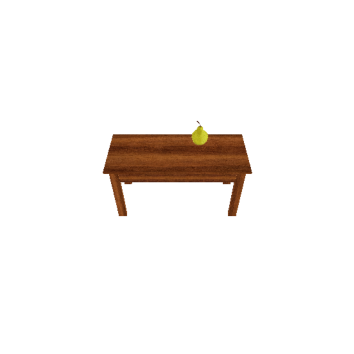

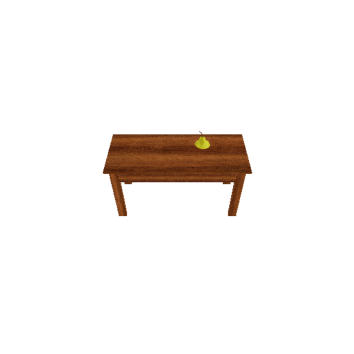

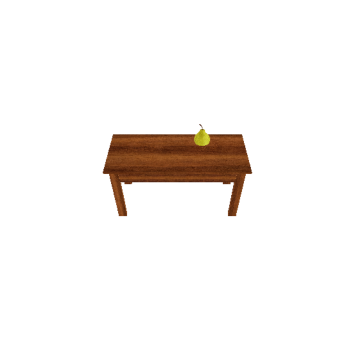

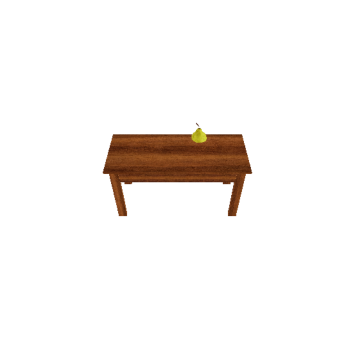

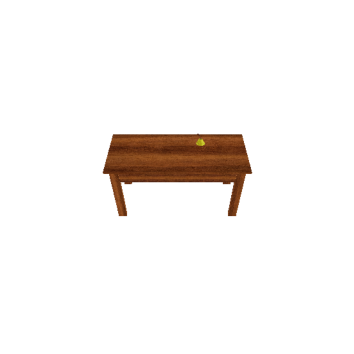

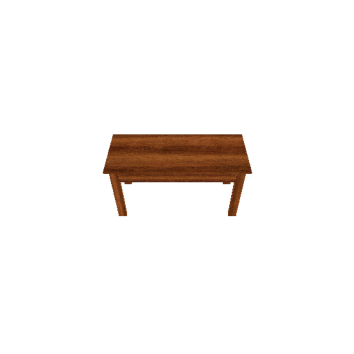

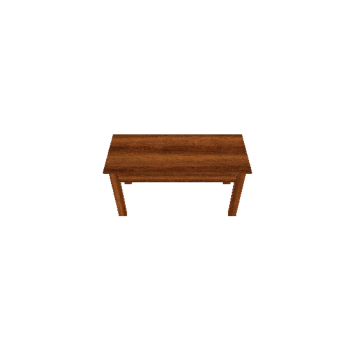

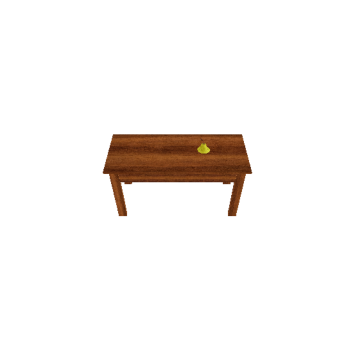

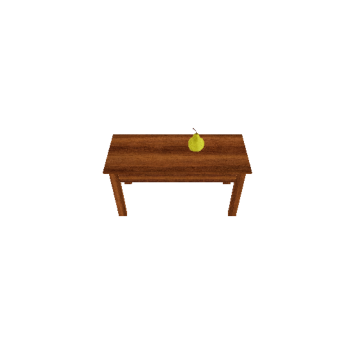

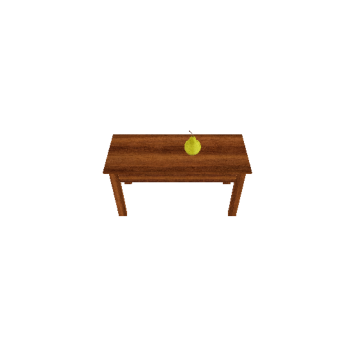

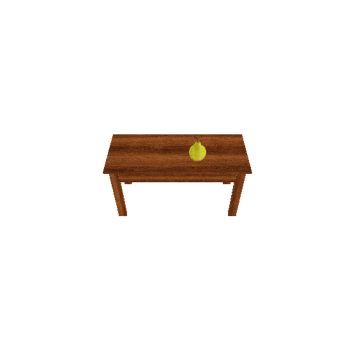

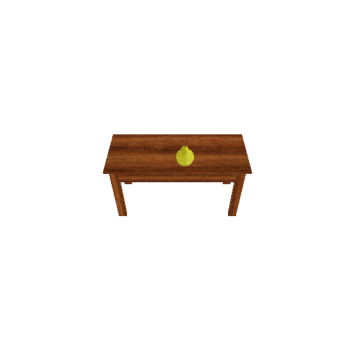

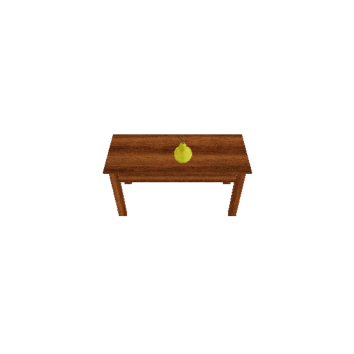

In [229]:
env = CustomTrain()

done = False
while not done:
  action = env.action_space.sample()
  state, reward, done, info = env.step(action)